In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.dummy import DummyRegressor
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import RFECV

import statsmodels.api as sm
from statsmodels.formula.api import ols

pd.set_option('display.max_columns', 50)
%matplotlib inline

### Load In Two Datasets

In [47]:
df = pd.read_csv('/Users/arencarpenter/Desktop/chsi_dataset/RISKFACTORSANDACCESSTOCARE.csv', na_values=['-1111.1', '-2222', '-2222.2'])
df_rural_urban = pd.read_csv('/Users/arencarpenter/Desktop/PctUrbanRural_County.csv')
df_income = pd.read_csv('/Users/arencarpenter/Desktop/2015 Median Income by County.csv')
df_demo = pd.read_csv('/Users/arencarpenter/Desktop/demographics.csv')

In [48]:
df_income = df_income.iloc[:3141]
df_income

,State,County,Median household income
0,Alabama,Autauga County,51281.0
1,Alabama,Baldwin County,50254.0
2,Alabama,Barbour County,32964.0
3,Alabama,Bibb County,38678.0
4,Alabama,Blount County,45813.0
...,...,...,...
3136,Wyoming,Sublette County,81772.0
3137,Wyoming,Sweetwater County,69022.0
3138,Wyoming,Teton County,75325.0
3139,Wyoming,Uinta County,56569.0


In [49]:
df_demo

,county,state,medincome,povertypercent,medianagemale,medianagefemale,percentmarried,no_hs_24,hs_24,college_24,hs_25,college_25,pctemployed,pctunemployed,pctprivatecoverage,pctprivatecoveragealone,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds
0,Autauga County,Alabama,54366,13.1,36.7,38.4,54.8,19.1,38.8,5.4,33.5,13.5,NaN,7.6,73.1,56.8,46.1,30.0,14.3,77.399902,18.679488,0.967023,0.925373,56.069818
1,Baldwin County,Alabama,49626,13.0,40.9,43.3,53.8,17.7,33.4,8.6,28.8,19.3,55.0,7.5,67.6,51.3,42.6,33.7,17.5,86.431496,9.601734,0.669841,0.958380,53.935010
2,Barbour County,Alabama,34971,25.4,36.6,41.9,41.5,25.1,43.4,1.8,34.5,7.5,39.5,17.6,52.7,35.7,30.3,46.6,26.5,47.363731,46.765929,0.905985,3.445715,43.276946
3,Bibb County,Alabama,39546,18.1,37.8,40.4,49.0,25.3,33.1,1.2,42.1,6.1,45.2,8.3,64.8,NaN,43.8,39.4,22.7,76.654574,21.438683,0.092904,0.030968,57.335990
4,Blount County,Alabama,45567,17.5,39.6,41.9,59.0,19.4,33.3,3.0,33.4,8.6,48.4,7.7,66.2,49.9,44.7,35.9,19.0,95.097903,1.531797,0.143823,0.961705,59.439854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3042,Sweetwater County,Wyoming,72604,9.8,33.9,33.4,55.2,16.9,35.5,4.0,35.4,13.8,68.4,5.4,74.2,62.7,59.0,21.9,11.3,92.133476,0.866613,0.857679,1.684088,54.385755
3043,Teton County,Wyoming,75348,7.7,38.2,37.9,47.7,7.4,25.2,26.7,17.9,37.8,76.5,2.6,77.0,67.2,46.1,14.4,5.5,93.160325,0.322711,1.900408,2.783380,50.580188
3044,Uinta County,Wyoming,56800,10.0,33.2,35.8,56.5,18.4,38.6,0.4,36.2,13.9,65.8,4.4,71.0,NaN,54.1,24.4,13.0,94.233158,0.195891,0.119446,1.538462,57.451346
3045,Washakie County,Wyoming,50802,12.6,43.7,43.1,56.0,34.2,52.3,0.2,29.3,15.0,58.7,6.8,66.8,49.3,43.8,32.2,13.9,91.238095,0.678571,0.166667,4.142857,51.708428


## Processing

Primary Care Physician Rate and Dentist Rate are per 100k population

In [50]:
df.Community_Health_Center_Ind = df.Community_Health_Center_Ind - 1
df.HPSA_Ind = df.HPSA_Ind - 1

In [51]:
df.shape

(3141, 31)

In [52]:
df_rural_urban.shape

(3221, 15)

In [53]:
df_income.shape

(3141, 3)

In [54]:
df_demo.shape

(3047, 24)

In [55]:
df = pd.concat([df, df_rural_urban, df_income, df_demo], axis=1)

In [56]:
df.head()

,State_FIPS_Code,County_FIPS_Code,CHSI_County_Name,CHSI_State_Name,CHSI_State_Abbr,Strata_ID_Number,No_Exercise,CI_Min_No_Exercise,CI_Max_No_Exercise,Few_Fruit_Veg,CI_Min_Fruit_Veg,CI_Max_Fruit_Veg,Obesity,CI_Min_Obesity,CI_Max_Obesity,High_Blood_Pres,CI_Min_High_Blood_Pres,CI_Max_High_Blood_Pres,Smoker,CI_Min_Smoker,CI_Max_Smoker,Diabetes,CI_Min_Diabetes,CI_Max_Diabetes,Uninsured,...,Median household income,county,state,medincome,povertypercent,medianagemale,medianagefemale,percentmarried,no_hs_24,hs_24,college_24,hs_25,college_25,pctemployed,pctunemployed,pctprivatecoverage,pctprivatecoveragealone,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds
0,1.0,1.0,Autauga,Alabama,AL,29.0,27.8,20.7,34.9,78.6,69.4,87.8,24.5,17.3,31.7,29.1,19.2,39.0,26.6,19.1,34.0,14.2,9.1,19.3,5690.0,...,51281.0,Autauga County,Alabama,54366.0,13.1,36.7,38.4,54.8,19.1,38.8,5.4,33.5,13.5,NaN,7.6,73.1,56.8,46.1,30.0,14.3,77.399902,18.679488,0.967023,0.925373,56.069818
1,1.0,3.0,Baldwin,Alabama,AL,16.0,27.2,23.2,31.2,76.2,71.2,81.3,23.6,19.5,27.6,30.5,24.5,36.6,24.6,20.3,28.8,7.2,5.2,9.3,19798.0,...,50254.0,Baldwin County,Alabama,49626.0,13.0,40.9,43.3,53.8,17.7,33.4,8.6,28.8,19.3,55.0,7.5,67.6,51.3,42.6,33.7,17.5,86.431496,9.601734,0.669841,0.958380,53.935010
2,1.0,5.0,Barbour,Alabama,AL,51.0,NaN,NaN,NaN,NaN,NaN,NaN,25.6,16.2,35.0,NaN,NaN,NaN,17.7,10.2,25.1,6.6,2.0,11.3,5126.0,...,32964.0,Barbour County,Alabama,34971.0,25.4,36.6,41.9,41.5,25.1,43.4,1.8,34.5,7.5,39.5,17.6,52.7,35.7,30.3,46.6,26.5,47.363731,46.765929,0.905985,3.445715,43.276946
3,1.0,7.0,Bibb,Alabama,AL,42.0,NaN,NaN,NaN,86.6,77.8,95.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.1,4.7,21.5,3315.0,...,38678.0,Bibb County,Alabama,39546.0,18.1,37.8,40.4,49.0,25.3,33.1,1.2,42.1,6.1,45.2,8.3,64.8,NaN,43.8,39.4,22.7,76.654574,21.438683,0.092904,0.030968,57.335990
4,1.0,9.0,Blount,Alabama,AL,28.0,33.5,26.3,40.6,74.6,66.1,83.0,24.2,17.2,31.2,NaN,NaN,NaN,23.6,16.7,30.4,8.4,4.4,12.4,8131.0,...,45813.0,Blount County,Alabama,45567.0,17.5,39.6,41.9,59.0,19.4,33.3,3.0,33.4,8.6,48.4,7.7,66.2,49.9,44.7,35.9,19.0,95.097903,1.531797,0.143823,0.961705,59.439854


In [57]:
df.drop(columns=['CI_Min_No_Exercise', 'CI_Max_No_Exercise', 'CI_Min_Fruit_Veg', 'CI_Max_Fruit_Veg', 'CI_Min_Obesity', 
               'CI_Max_Obesity', 'CI_Min_High_Blood_Pres', 'CI_Max_High_Blood_Pres', 'CI_Min_Smoker', 'CI_Max_Smoker',
               'CI_Min_Diabetes', 'CI_Max_Diabetes', 'STATE', 'COUNTY', 'STATENAME', 'COUNTYNAME', 'POPDEN_URBAN',
               'POPDEN_RURAL', 'County_FIPS_Code', 'State', 'County', 'county', 'state'], inplace=True)

In [58]:
df = df[df.State_FIPS_Code.notnull()] # Remove US territories from the list.

In [59]:
df.shape # We now have only the 3141 US counties.

(3141, 50)

In [60]:
df.head(15)

,State_FIPS_Code,CHSI_County_Name,CHSI_State_Name,CHSI_State_Abbr,Strata_ID_Number,No_Exercise,Few_Fruit_Veg,Obesity,High_Blood_Pres,Smoker,Diabetes,Uninsured,Elderly_Medicare,Disabled_Medicare,Prim_Care_Phys_Rate,Dentist_Rate,Community_Health_Center_Ind,HPSA_Ind,POP_COU,POP_URBAN,POPPCT_URBAN,AREA_URBAN,AREAPCT_URBAN,POP_RURAL,POPPCT_RURAL,AREA_RURAL,AREAPCT_RURAL,Median household income,medincome,povertypercent,medianagemale,medianagefemale,percentmarried,no_hs_24,hs_24,college_24,hs_25,college_25,pctemployed,pctunemployed,pctprivatecoverage,pctprivatecoveragealone,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds
0,1.0,Autauga,Alabama,AL,29.0,27.8,78.6,24.5,29.1,26.6,14.2,5690.0,4762.0,1209.0,45.3,22.6,0.0,1.0,54571,31650,58.00,50882539,3.30,22921,42.00,1.488700e+09,96.70,51281.0,54366.0,13.1,36.7,38.4,54.8,19.1,38.8,5.4,33.5,13.5,NaN,7.6,73.1,56.8,46.1,30.0,14.3,77.399902,18.679488,0.967023,0.925373,56.069818
1,1.0,Baldwin,Alabama,AL,16.0,27.2,76.2,23.6,30.5,24.6,7.2,19798.0,22635.0,3839.0,67.0,30.8,0.0,1.0,182265,105205,57.72,275001368,6.68,77060,42.28,3.842520e+09,93.32,50254.0,49626.0,13.0,40.9,43.3,53.8,17.7,33.4,8.6,28.8,19.3,55.0,7.5,67.6,51.3,42.6,33.7,17.5,86.431496,9.601734,0.669841,0.958380,53.935010
2,1.0,Barbour,Alabama,AL,51.0,NaN,NaN,25.6,NaN,17.7,6.6,5126.0,3288.0,1092.0,45.8,24.6,0.0,1.0,27457,8844,32.21,17447656,0.76,18613,67.79,2.274371e+09,99.24,32964.0,34971.0,25.4,36.6,41.9,41.5,25.1,43.4,1.8,34.5,7.5,39.5,17.6,52.7,35.7,30.3,46.6,26.5,47.363731,46.765929,0.905985,3.445715,43.276946
3,1.0,Bibb,Alabama,AL,42.0,NaN,86.6,NaN,NaN,NaN,13.1,3315.0,2390.0,974.0,41.8,18.6,0.0,0.0,22915,7252,31.65,18903236,1.17,15663,68.35,1.593578e+09,98.83,38678.0,39546.0,18.1,37.8,40.4,49.0,25.3,33.1,1.2,42.1,6.1,45.2,8.3,64.8,NaN,43.8,39.4,22.7,76.654574,21.438683,0.092904,0.030968,57.335990
4,1.0,Blount,Alabama,AL,28.0,33.5,74.6,24.2,NaN,23.6,8.4,8131.0,5019.0,1300.0,16.2,10.8,1.0,0.0,57322,5760,10.05,10874700,0.65,51562,89.95,1.659087e+09,99.35,45813.0,45567.0,17.5,39.6,41.9,59.0,19.4,33.3,3.0,33.4,8.6,48.4,7.7,66.2,49.9,44.7,35.9,19.0,95.097903,1.531797,0.143823,0.961705,59.439854
5,1.0,Bullock,Alabama,AL,75.0,NaN,NaN,NaN,NaN,NaN,NaN,2295.0,1433.0,504.0,54.3,18.1,0.0,0.0,10914,5307,48.63,12675709,0.79,5607,51.37,1.600381e+09,99.21,31938.0,26580.0,35.1,37.9,40.6,28.9,8.2,65.5,0.0,33.3,6.5,44.7,18.0,48.1,35.9,32.4,44.3,28.9,26.643566,70.706125,0.206031,0.000000,31.794733
6,1.0,Butler,Alabama,AL,76.0,24.5,NaN,22.0,NaN,27.3,9.5,4055.0,3150.0,952.0,43.3,19.3,0.0,1.0,20947,6026,28.77,10503875,0.52,14921,71.23,2.001473e+09,99.48,32229.0,41123.0,20.5,37.5,40.6,48.2,13.9,28.3,4.8,31.8,10.7,50.8,12.3,65.0,46.0,39.3,39.7,20.2,75.110589,20.484706,0.857280,0.996159,47.191832
7,1.0,Calhoun,Alabama,AL,6.0,29.2,81.9,27.0,33.2,25.5,11.2,16456.0,16440.0,5301.0,75.8,41.9,0.0,1.0,118572,78617,66.30,210145581,13.39,39955,33.70,1.359044e+09,86.61,41703.0,34116.0,21.3,41.5,43.9,43.9,14.2,42.6,3.9,38.4,7.6,49.8,8.9,57.7,42.2,38.6,42.2,24.1,57.666011,40.312216,0.762933,0.035212,40.552695
8,1.0,Chambers,Alabama,AL,50.0,34.7,84.6,NaN,NaN,11.7,17.1,5533.0,5473.0,1497.0,53.6,22.6,0.0,1.0,34215,17399,50.85,54790707,3.55,16816,49.15,1.490219e+09,96.45,34177.0,38013.0,18.6,44.6,46.2,62.1,15.8,38.3,5.5,36.4,7.9,47.8,7.9,66.3,45.6,39.9,43.3,20.3,92.921409,4.925408,0.338357,0.065365,57.173258
9,1.0,Cherokee,Alabama,AL,64.0,NaN,NaN,NaN,NaN,23.6,13.3,3583.0,3086.0,854.0,28.5,12.2,1.0,0.0,25989,3707,14.26,26419773,1.84,22282,85.74,1.407656e+09,98.16,36296.0,41450.0,18.1,37.6,39.6,54.4,13.5,41.9,3.6,39.2,9.1,52.1,9.1,60.8,NaN,41.3,35.1,20.4,84.045734,10.333417,0.287546,4.119218,54.862351


In [61]:
df.isnull().sum()

State_FIPS_Code                   0
CHSI_County_Name                  0
CHSI_State_Name                   0
CHSI_State_Abbr                   0
Strata_ID_Number                  0
No_Exercise                     935
Few_Fruit_Veg                  1237
Obesity                         917
High_Blood_Pres                1619
Smoker                          874
Diabetes                        422
Uninsured                         3
Elderly_Medicare                 31
Disabled_Medicare                32
Prim_Care_Phys_Rate               0
Dentist_Rate                      1
Community_Health_Center_Ind       0
HPSA_Ind                          0
POP_COU                           0
POP_URBAN                         0
POPPCT_URBAN                      0
AREA_URBAN                        0
AREAPCT_URBAN                     0
POP_RURAL                         0
POPPCT_RURAL                      0
AREA_RURAL                        0
AREAPCT_RURAL                     0
Median household income     

### Imputing Missing Community Indicators

Using the state average for each missing indicator. I looked at histograms for the CHSI values and they were normally distributed, so I used the mean to impute.

In [62]:
def impute_state_avg(column, state):
    state_avg = df[df.CHSI_State_Name == state][column].mean()
    print(state + " State Avg for " + column + ": " + str(state_avg))

    df[column] = df[column].fillna(state_avg)

In [63]:
states = df.CHSI_State_Name.unique()
columns = ['No_Exercise','Few_Fruit_Veg', 'Obesity', 'High_Blood_Pres', 'Smoker', 'Diabetes', 'Elderly_Medicare', 
           'Disabled_Medicare', 'Dentist_Rate']

In [64]:
def impute():
    for column in columns:
        for state in states:
            impute_state_avg(column, state)

In [65]:
impute()

Alabama State Avg for No_Exercise: 29.794999999999995
Alaska State Avg for No_Exercise: 29.794999999999987
Arizona State Avg for No_Exercise: 25.652999999999995
Arkansas State Avg for No_Exercise: 31.0486
California State Avg for No_Exercise: 24.272413793103446
Colorado State Avg for No_Exercise: 24.02242187500001
Connecticut State Avg for No_Exercise: 20.9375
Delaware State Avg for No_Exercise: 25.933333333333334
District of Columbia State Avg for No_Exercise: 22.2
Florida State Avg for No_Exercise: 27.122835820895528
Georgia State Avg for No_Exercise: 28.849905660377388
Hawaii State Avg for No_Exercise: 21.238999999999997
Idaho State Avg for No_Exercise: 22.9475
Illinois State Avg for No_Exercise: 27.300196078431398
Indiana State Avg for No_Exercise: 27.686304347826102
Iowa State Avg for No_Exercise: 25.966868686868693
Kansas State Avg for No_Exercise: 28.326809523809548
Kentucky State Avg for No_Exercise: 34.45500000000002
Louisiana State Avg for No_Exercise: 34.683671875000016
Main

Idaho State Avg for Elderly_Medicare: 3665.710312075984
Illinois State Avg for Elderly_Medicare: 14170.843137254902
Indiana State Avg for Elderly_Medicare: 8112.652173913043
Iowa State Avg for Elderly_Medicare: 4299.262626262626
Kansas State Avg for Elderly_Medicare: 3282.504761904762
Kentucky State Avg for Elderly_Medicare: 4158.566666666667
Louisiana State Avg for Elderly_Medicare: 7870.171875
Maine State Avg for Elderly_Medicare: 11529.8125
Maryland State Avg for Elderly_Medicare: 24542.708333333332
Massachusetts State Avg for Elderly_Medicare: 58704.57142857143
Michigan State Avg for Elderly_Medicare: 14669.819277108434
Minnesota State Avg for Elderly_Medicare: 6834.045977011494
Mississippi State Avg for Elderly_Medicare: 4091.609756097561
Missouri State Avg for Elderly_Medicare: 6437.55652173913
Montana State Avg for Elderly_Medicare: 2338.325959488273
Nebraska State Avg for Elderly_Medicare: 3248.2826191622535
Nevada State Avg for Elderly_Medicare: 13906.058823529413
New Hampshir

In [66]:
df.isnull().sum() # Now just missing 3 values for uninsured, our target, so dropping those.

State_FIPS_Code                  0
CHSI_County_Name                 0
CHSI_State_Name                  0
CHSI_State_Abbr                  0
Strata_ID_Number                 0
No_Exercise                      0
Few_Fruit_Veg                    0
Obesity                          0
High_Blood_Pres                  0
Smoker                           0
Diabetes                         0
Uninsured                        3
Elderly_Medicare                 0
Disabled_Medicare                0
Prim_Care_Phys_Rate              0
Dentist_Rate                     0
Community_Health_Center_Ind      0
HPSA_Ind                         0
POP_COU                          0
POP_URBAN                        0
POPPCT_URBAN                     0
AREA_URBAN                       0
AREAPCT_URBAN                    0
POP_RURAL                        0
POPPCT_RURAL                     0
AREA_RURAL                       0
AREAPCT_RURAL                    0
Median household income          1
medincome           

### Dropping Missing Values from Target Variable

In [67]:
df[df.Uninsured.isnull()]

,State_FIPS_Code,CHSI_County_Name,CHSI_State_Name,CHSI_State_Abbr,Strata_ID_Number,No_Exercise,Few_Fruit_Veg,Obesity,High_Blood_Pres,Smoker,Diabetes,Uninsured,Elderly_Medicare,Disabled_Medicare,Prim_Care_Phys_Rate,Dentist_Rate,Community_Health_Center_Ind,HPSA_Ind,POP_COU,POP_URBAN,POPPCT_URBAN,AREA_URBAN,AREAPCT_URBAN,POP_RURAL,POPPCT_RURAL,AREA_RURAL,AREAPCT_RURAL,Median household income,medincome,povertypercent,medianagemale,medianagefemale,percentmarried,no_hs_24,hs_24,college_24,hs_25,college_25,pctemployed,pctunemployed,pctprivatecoverage,pctprivatecoveragealone,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds
249,8.0,Broomfield,Colorado,CO,27.0,14.400,80.08,21.500000,15.9,17.400000,3.300000,NaN,8486.253731,2246.58209,87.4,23.977612,1.0,1.0,6499,4032,62.04,3651419,0.09,2467,37.96,3.914641e+09,99.91,36791.0,83603.0,5.9,45.1,45.2,62.6,18.2,32.9,11.0,27.0,22.0,64.7,6.7,77.9,63.1,51.7,22.9,10.8,95.275624,0.528191,0.838399,0.301824,68.195319
317,11.0,Washington,District of Columbia,DC,3.0,22.200,68.10,21.300000,26.7,20.400000,7.800000,NaN,63403.000000,10262.00000,227.6,102.800000,0.0,1.0,538479,513696,95.40,543209334,49.20,24783,4.60,5.608655e+08,50.80,65476.0,36788.0,25.3,39.1,48.7,49.8,37.6,20.3,1.4,35.4,10.1,43.9,9.4,52.8,34.1,28.7,43.3,20.9,81.991744,14.551084,0.756794,0.455796,50.507146
546,15.0,Kalawao,Hawaii,HI,37.0,29.795,80.08,26.897561,31.6,23.822917,9.651563,NaN,8486.253731,2246.58209,0.0,0.000000,1.0,1.0,185079,114766,62.01,224652200,2.15,70313,37.99,1.020890e+10,97.85,52108.0,44669.0,17.1,35.3,37.2,59.1,23.0,44.2,4.3,33.1,8.9,59.9,3.8,50.5,34.9,27.3,37.6,22.4,86.437340,0.072212,0.597387,9.440032,59.883612


In [68]:
df.shape

(3141, 50)

In [69]:
df = df.drop(columns='pctprivatecoveragealone')

In [70]:
df = df.dropna()

In [71]:
df.shape

(2891, 49)

## Removing Correlated Features

In [72]:
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(to_drop)
# Drop features 
df.drop(to_drop, axis=1, inplace=True)

['Disabled_Medicare', 'POP_URBAN', 'POPPCT_RURAL', 'AREAPCT_RURAL']


In [73]:
df.shape

(2891, 45)

## Feature Engineering

In [74]:
df['Percent_Uninsured'] = round(df.Uninsured / df.POP_COU * 100, 3)

In [75]:
df['CHC_x_POPPCT_URBAN'] = df.Community_Health_Center_Ind * df.POPPCT_URBAN

In [76]:
df['HPSA_x_POPPCT_URBAN'] = df.HPSA_Ind * df.POPPCT_URBAN

In [77]:
df['Median_Household_Income'] = df['Median household income']

In [78]:
df

,State_FIPS_Code,CHSI_County_Name,CHSI_State_Name,CHSI_State_Abbr,Strata_ID_Number,No_Exercise,Few_Fruit_Veg,Obesity,High_Blood_Pres,Smoker,Diabetes,Uninsured,Elderly_Medicare,Prim_Care_Phys_Rate,Dentist_Rate,Community_Health_Center_Ind,HPSA_Ind,POP_COU,POPPCT_URBAN,AREA_URBAN,AREAPCT_URBAN,POP_RURAL,AREA_RURAL,Median household income,medincome,povertypercent,medianagemale,medianagefemale,percentmarried,no_hs_24,hs_24,college_24,hs_25,college_25,pctemployed,pctunemployed,pctprivatecoverage,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds,Percent_Uninsured,CHC_x_POPPCT_URBAN,HPSA_x_POPPCT_URBAN,Median_Household_Income
1,1.0,Baldwin,Alabama,AL,16.0,27.200,76.20,23.600000,30.5,24.600000,7.200000,19798.0,22635.0,67.0,30.8,0.0,1.0,182265,57.72,275001368,6.68,77060,3.842520e+09,50254.0,49626.0,13.0,40.9,43.3,53.8,17.7,33.4,8.6,28.8,19.3,55.0,7.5,67.6,42.6,33.7,17.5,86.431496,9.601734,0.669841,0.958380,53.935010,10.862,0.00,57.72,50254.0
2,1.0,Barbour,Alabama,AL,51.0,29.795,80.08,25.600000,31.6,17.700000,6.600000,5126.0,3288.0,45.8,24.6,0.0,1.0,27457,32.21,17447656,0.76,18613,2.274371e+09,32964.0,34971.0,25.4,36.6,41.9,41.5,25.1,43.4,1.8,34.5,7.5,39.5,17.6,52.7,30.3,46.6,26.5,47.363731,46.765929,0.905985,3.445715,43.276946,18.669,0.00,32.21,32964.0
3,1.0,Bibb,Alabama,AL,42.0,29.795,86.60,26.897561,31.6,23.822917,13.100000,3315.0,2390.0,41.8,18.6,0.0,0.0,22915,31.65,18903236,1.17,15663,1.593578e+09,38678.0,39546.0,18.1,37.8,40.4,49.0,25.3,33.1,1.2,42.1,6.1,45.2,8.3,64.8,43.8,39.4,22.7,76.654574,21.438683,0.092904,0.030968,57.335990,14.467,0.00,0.00,38678.0
4,1.0,Blount,Alabama,AL,28.0,33.500,74.60,24.200000,31.6,23.600000,8.400000,8131.0,5019.0,16.2,10.8,1.0,0.0,57322,10.05,10874700,0.65,51562,1.659087e+09,45813.0,45567.0,17.5,39.6,41.9,59.0,19.4,33.3,3.0,33.4,8.6,48.4,7.7,66.2,44.7,35.9,19.0,95.097903,1.531797,0.143823,0.961705,59.439854,14.185,10.05,0.00,45813.0
5,1.0,Bullock,Alabama,AL,75.0,29.795,80.08,26.897561,31.6,23.822917,9.651563,2295.0,1433.0,54.3,18.1,0.0,0.0,10914,48.63,12675709,0.79,5607,1.600381e+09,31938.0,26580.0,35.1,37.9,40.6,28.9,8.2,65.5,0.0,33.3,6.5,44.7,18.0,48.1,32.4,44.3,28.9,26.643566,70.706125,0.206031,0.000000,31.794733,21.028,0.00,0.00,31938.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3042,54.0,Wetzel,West Virginia,WV,73.0,26.200,77.10,29.700000,31.6,27.500000,9.100000,2122.0,3303.0,70.1,52.6,1.0,1.0,42481,34.81,40178346,3.07,27692,1.270308e+09,29086.0,72604.0,9.8,33.9,33.4,55.2,16.9,35.5,4.0,35.4,13.8,68.4,5.4,74.2,59.0,21.9,11.3,92.133476,0.866613,0.857679,1.684088,54.385755,4.995,34.81,34.81,29086.0
3043,54.0,Wirt,West Virginia,WV,71.0,29.795,80.08,26.897561,31.6,21.800000,4.700000,829.0,816.0,17.0,17.0,0.0,0.0,9154,0.00,0,0.00,9154,1.433476e+09,39096.0,75348.0,7.7,38.2,37.9,47.7,7.4,25.2,26.7,17.9,37.8,76.5,2.6,77.0,46.1,14.4,5.5,93.160325,0.322711,1.900408,2.783380,50.580188,9.056,0.00,0.00,39096.0
3044,54.0,Wood,West Virginia,WV,24.0,25.900,77.70,25.000000,32.6,26.300000,9.800000,9946.0,13456.0,82.7,39.1,0.0,1.0,16583,46.14,8972452,0.97,8931,9.184059e+08,39352.0,56800.0,10.0,33.2,35.8,56.5,18.4,38.6,0.4,36.2,13.9,65.8,4.4,71.0,54.1,24.4,13.0,94.233158,0.195891,0.119446,1.538462,57.451346,59.977,0.00,46.14,39352.0
3045,54.0,Wyoming,West Virginia,WV,52.0,38.200,85.10,26.900000,40.2,35.300000,10.500000,4316.0,3322.0,20.4,24.5,0.0,0.0,5717,0.00,0,0.00,5717,6.021952e+08,41884.0,50802.0,12.6,43.7,43.1,56.0,34.2,52.3,0.2,29.3,15.0,58.7,6.8,66.8,43.8,32.2,13.9,91.238095,0.678571,0.166667,4.142857,51.708428,75.494,0.00,0.00,41884.0


In [79]:
df = df[df.Percent_Uninsured <= 100] # Remove percents greater than 100%

In [80]:
formula = 'Percent_Uninsured ~ No_Exercise + Few_Fruit_Veg + Obesity + High_Blood_Pres + Smoker + Diabetes + Elderly_Medicare\
+ Prim_Care_Phys_Rate + Dentist_Rate + POP_COU + POPPCT_URBAN + AREA_URBAN + AREAPCT_URBAN + POP_RURAL + AREA_RURAL \
+ CHC_x_POPPCT_URBAN + HPSA_x_POPPCT_URBAN + C(Community_Health_Center_Ind) + C(HPSA_Ind) + Median_Household_Income \
+ povertypercent + medianagemale + percentmarried + no_hs_24 + hs_24 + college_24 + hs_25 + college_25 \
+ pctemployed + pctunemployed + pctprivatecoverage + pctempprivcoverage + pctpubliccoverage + pctpubliccoveragealone \
+ pctwhite + pctblack + pctasian + pctotherrace + pctmarriedhouseholds'

In [81]:
model = ols(formula=formula, data=df).fit()

In [82]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Percent_Uninsured   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     42.36
Date:                Wed, 29 Jul 2020   Prob (F-statistic):          6.33e-244
Time:                        17:16:45   Log-Likelihood:                -10942.
No. Observations:                2599   AIC:                         2.196e+04
Df Residuals:                    2559   BIC:                         2.220e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                57.9583     16.035      3.614      0.000      26.515      89.402
C(Community_Health_Center_Ind)[T.1.0]    -9.1776      1.172     -7.832      0.000     -11.475      -6.880
C(HPSA_Ind)[T.1.0]                        5.9175      1.249      4.736      0.000       3.468       8.367
No_Exercise                              -0.1281      0.079     -1.612      0.107      -0.284       0.028
Few_Fruit_Veg                            -0.0438      0.094     -0.464      0.642      -0.229       0.141
Obesity                                   0.0810      0.095      0.854      0.393      -0.105       0.267
High_Blood_Pres                          -0.5108      0.091     -5.598      0.000      -0.690      -0.332
Smoker                                    0.3452      0.076      4.558      0.000       0.197       0.494
Diabetes                                 -0.0790      0.143     -0.552      0.581      -0.360       0.202
Elderly_Medicare                          0.0004   2.39e-05     18.605      0.000       0.000       0.000
Prim_Care_Phys_Rate                       0.0464      0.010      4.863      0.000       0.028       0.065
Dentist_Rate                              0.0236      0.019      1.219      0.223      -0.014       0.062
POP_COU                               -5.811e-06   2.07e-06     -2.811      0.005   -9.86e-06   -1.76e-06
POPPCT_URBAN                             -0.2314      0.025     -9.265      0.000      -0.280      -0.182
AREA_URBAN                             8.018e-09   3.54e-09      2.266      0.024    1.08e-09     1.5e-08
AREAPCT_URBAN                            -0.0841      0.027     -3.143      0.002      -0.137      -0.032
POP_RURAL                                -0.0004   2.33e-05    -16.546      0.000      -0.000      -0.000
AREA_RURAL                            -3.763e-11    4.9e-11     -0.768      0.442   -1.34e-10    5.84e-11
CHC_x_POPPCT_URBAN                        0.0801      0.022      3.685      0.000       0.037       0.123
HPSA_x_POPPCT_URBAN                      -0.0634      0.024     -2.652      0.008      -0.110      -0.017
Median_Household_Income                  -0.0002   2.97e-05     -5.775      0.000      -0.000      -0.000
povertypercent                            0.0998      0.131      0.760      0.447      -0.158       0.357
medianagemale                             0.1102      0.131      0.840      0.401      -0.147       0.367
percentmarried                           -0.0816      0.153     -0.533      0.594      -0.382       0.219
no_hs_24                                 -0.0140      0.051     -0.276      0.783      -0.113       0.085
hs_24                                     0.0175      0.045      0.391      0.696      -0.070       0.105
college_2

In [83]:
significant_formula = 'Percent_Uninsured ~ No_Exercise + High_Blood_Pres + Smoker + Elderly_Medicare \
+ Prim_Care_Phys_Rate + POP_COU + POPPCT_URBAN + AREA_URBAN + AREAPCT_URBAN + POP_RURAL\
+ CHC_x_POPPCT_URBAN + HPSA_x_POPPCT_URBAN + C(Community_Health_Center_Ind) + C(HPSA_Ind) + Median_Household_Income \
+ povertypercent + college_25 \
+ pctemployed'

In [84]:
model2 = ols(formula=significant_formula, data=df).fit()

In [85]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Percent_Uninsured   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     91.43
Date:                Wed, 29 Jul 2020   Prob (F-statistic):          3.95e-260
Time:                        17:17:08   Log-Likelihood:                -10948.
No. Observations:                2599   AIC:                         2.193e+04
Df Residuals:                    2580   BIC:                         2.205e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                50.2631      5.539      9.075      0.000      39.403      61.124
C(Community_Health_Center_Ind)[T.1.0]    -9.0405      1.154     -7.832      0.000     -11.304      -6.777
C(HPSA_Ind)[T.1.0]                        6.0204      1.237      4.867      0.000       3.595       8.446
No_Exercise                              -0.1135      0.074     -1.536      0.125      -0.258       0.031
High_Blood_Pres                          -0.5079      0.087     -5.823      0.000      -0.679      -0.337
Smoker                                    0.3504      0.075      4.673      0.000       0.203       0.497
Elderly_Medicare                          0.0004   2.32e-05     19.327      0.000       0.000       0.000
Prim_Care_Phys_Rate                       0.0514      0.008      6.148      0.000       0.035       0.068
POP_COU                               -5.774e-06   2.04e-06     -2.828      0.005   -9.78e-06   -1.77e-06
POPPCT_URBAN                             -0.2289      0.025     -9.221      0.000      -0.278      -0.180
AREA_URBAN                             8.104e-09    3.5e-09      2.314      0.021    1.24e-09     1.5e-08
AREAPCT_URBAN                            -0.0834      0.026     -3.188      0.001      -0.135      -0.032
POP_RURAL                                -0.0004   2.29e-05    -16.891      0.000      -0.000      -0.000
CHC_x_POPPCT_URBAN                        0.0787      0.022      3.641      0.000       0.036       0.121
HPSA_x_POPPCT_URBAN                      -0.0641      0.024     -2.696      0.007      -0.111      -0.017
Median_Household_Income                  -0.0002    2.9e-05     -5.975      0.000      -0.000      -0.000
povertypercent                            0.1011      0.076      1.324      0.186      -0.049       0.251
college_25                                0.1842      0.078      2.356      0.019       0.031       0.338
pctemployed                              -0.0826      0.064     -1.288      0.198      -0.208       0.043
==============================================================================
Omnibus:                      751.740   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2598.803
Skew:                           1.421   Prob(JB):                         0.00
Kurtosis:                       6.991   Cond. No.                     4.36e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.36e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

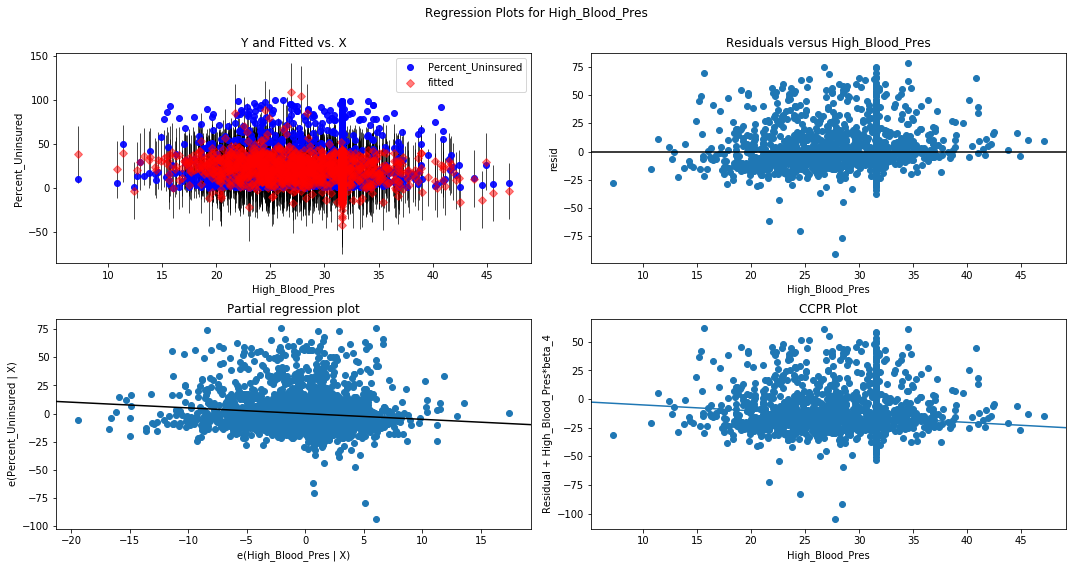

In [175]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model2, "High_Blood_Pres", fig=fig)
plt.show()

In [199]:
m, b = np.polyfit(df.Percent_Uninsured, df.pctunemployed, 1)

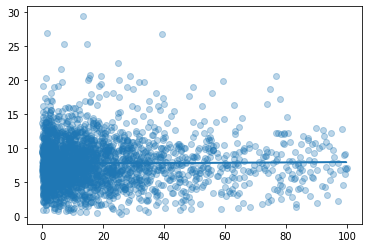

In [201]:
plt.scatter(df.Percent_Uninsured, df.pctunemployed, alpha=0.3)
plt.plot(df.Percent_Uninsured, m*df.Percent_Uninsured + b)
plt.show()

In [206]:
m2, b2 = np.polyfit(df.Percent_Uninsured, df.Smoker, 1)

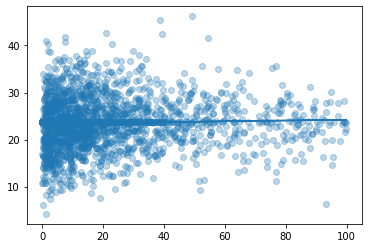

In [210]:
plt.scatter(df.Percent_Uninsured, df.Smoker, alpha=0.3)
plt.plot(df.Percent_Uninsured, m2*df.Percent_Uninsured + b2)
plt.show()

In [209]:
m3, b3 = np.polyfit(df.Percent_Uninsured, df.college_25, 1)

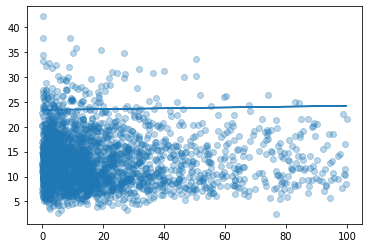

In [214]:
plt.scatter(df.Percent_Uninsured, df.college_25, alpha=0.3)
plt.plot(df.Percent_Uninsured, m*df.Percent_Uninsured + b)
plt.show()

### Stat Test: Two Proportion Z-Test 
#### Do rural and urban counties have different incidence of Community Health Centers?

In [92]:
import statsmodels.stats as sms

In [97]:
df_rural = df[df.POPPCT_URBAN <= 75]
df_urban = df[df.POPPCT_URBAN > 75]

In [101]:
len(df_rural)

2091

In [102]:
len(df_urban)

508

In [105]:
df_rural_CHC = df_rural[df_rural.Community_Health_Center_Ind == 1.0]

In [106]:
len(df_rural_CHC)

1240

In [107]:
df_urban_CHC = df_urban[df_urban.Community_Health_Center_Ind == 1.0]

In [108]:
len(df_urban_CHC)

253

In [109]:
sms.proportion.proportions_ztest([len(df_rural_CHC), len(df_urban_CHC)], [len(df_rural), len(df_urban)])

(3.8838732946017176, 0.00010280549625075338)

P-value = 0.0001, so can reject null hypothesis and conclude that there is a difference between rural and urban counties regarding the presence of community health centers.

### Stat Test 2: Two Proportion Z-Test 
#### Do rural and urban counties have a different rate of underservedness?

In [111]:
df_rural = df[df.POPPCT_URBAN <= 75]
df_urban = df[df.POPPCT_URBAN > 75]

In [112]:
len(df_rural)

2091

In [113]:
len(df_urban)

508

In [114]:
df_rural_HPSA = df_rural[df_rural.HPSA_Ind == 1.0]

In [115]:
len(df_rural_HPSA)

1519

In [116]:
df_urban_HPSA = df_urban[df_urban.HPSA_Ind == 1.0]

In [118]:
len(df_urban_HPSA)

394

In [120]:
sms.proportion.proportions_ztest([len(df_rural_HPSA), len(df_urban_HPSA)], [len(df_rural), len(df_urban)])

(-2.254041286737303, 0.024193570745392797)

P-value = 0.024, so can reject null hypothesis and conclude that there is a difference between rural and urban counties regarding their underservedness.

### Stat Test 3: Two Means T-Test 
#### Do rural and urban counties have a different rate of uninsured?

In [124]:
import scipy.stats

In [128]:
df_rural = df[df.POPPCT_URBAN <= 75]
df_urban = df[df.POPPCT_URBAN > 75]

In [129]:
len(df_rural)

2091

In [130]:
len(df_urban)

508

In [136]:
rural = df_rural.Percent_Uninsured

In [137]:
urban = df_urban.Percent_Uninsured

In [139]:
scipy.stats.ttest_ind(rural, urban)

Ttest_indResult(statistic=11.917737293476847, pvalue=6.399598718670862e-32)

In [141]:
rural.mean()

21.163396461023442

In [142]:
urban.mean()

9.157561023622048

P-value = 6.39 x 10<sup>-32</sup>, so we can reject the null hypothesis and conclude that there is a significant difference between rural and urban counties and their respective rates of uninsured.

### Visualizations

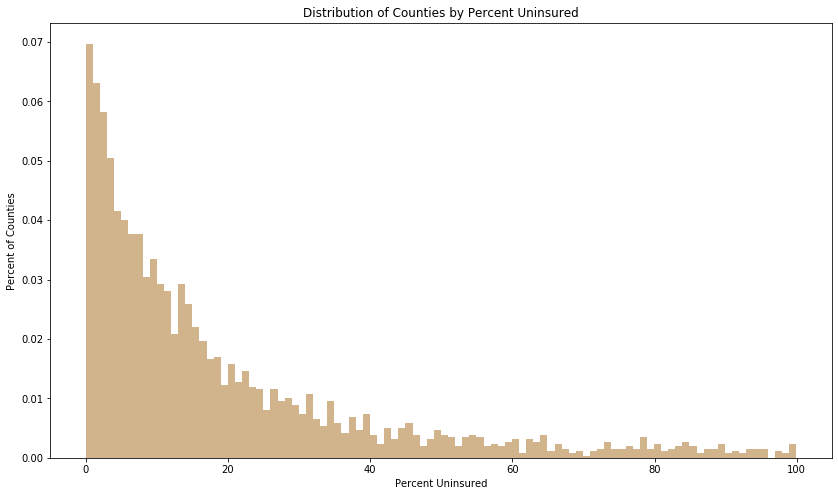

In [239]:
plt.figure(figsize=(14,8))
plt.hist(df.Percent_Uninsured, bins=100, density=True, color='tan')
plt.title('Distribution of Counties by Percent Uninsured')
plt.xlabel('Percent Uninsured')
plt.ylabel('Percent of Counties')
plt.show()

In [158]:
x = ['Urban', 'Rural']
y = [urban.mean(), rural.mean()]

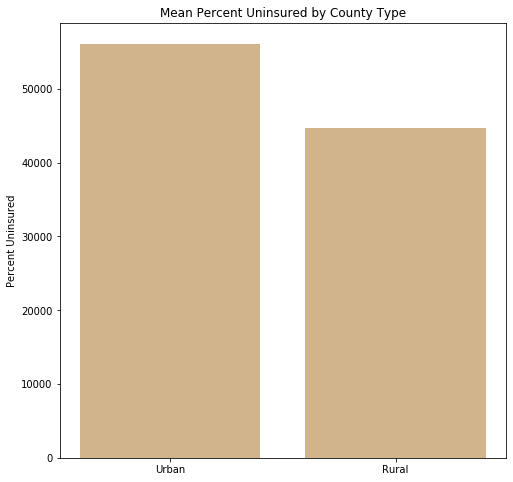

In [241]:
plt.figure(figsize=(8,8))
plt.bar(x, y, color ='tan')
plt.title('Mean Percent Uninsured by County Type')
plt.ylabel('Percent Uninsured')
plt.show()

In [186]:
x = ['Urban', 'Rural']
y = [df_urban.HPSA_Ind.mean(), df_rural.HPSA_Ind.mean()]

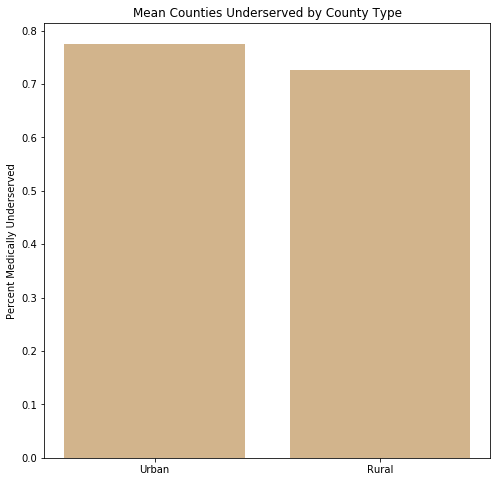

In [191]:
plt.figure(figsize=(8,8))
plt.bar(x, y, color ='tan')
plt.title('Mean Counties Underserved by County Type')
plt.ylabel('Percent Medically Underserved')
plt.show()

In [199]:
x = ['Urban', 'Rural']
y = [df_urban.POPPCT_URBAN.mean(), df_rural.POPPCT_URBAN.mean()]

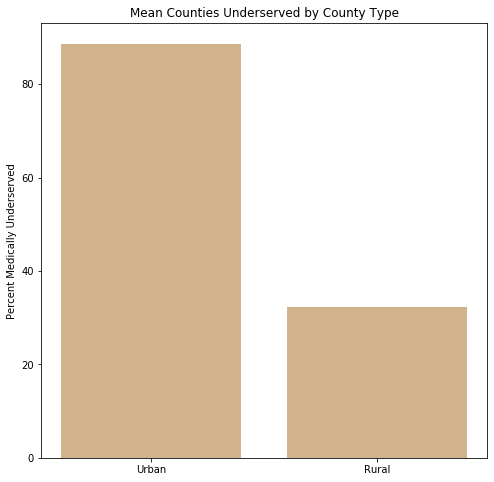

In [200]:
plt.figure(figsize=(8,8))
plt.bar(x, y, color ='tan')
plt.title('Mean Counties Underserved by County Type')
plt.ylabel('Percent Medically Underserved')
plt.show()

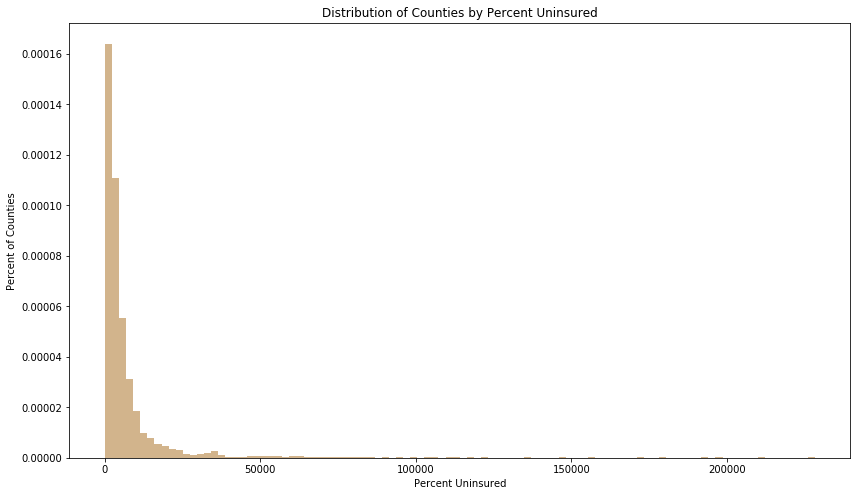

In [195]:
plt.figure(figsize=(14,8))
plt.hist(df.Elderly_Medicare, bins=100, density=True, color='tan')
plt.title('Distribution of Counties by Percent Uninsured')
plt.xlabel('Percent Uninsured')
plt.ylabel('Percent of Counties')
plt.show()

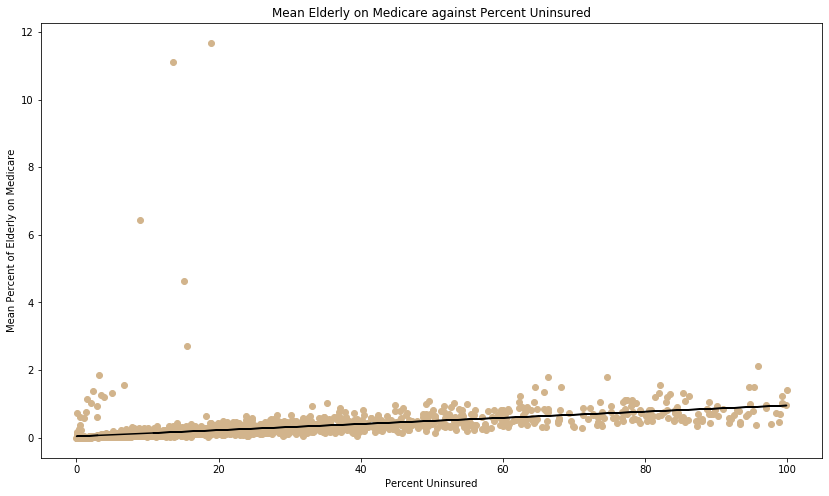

In [216]:
plt.figure(figsize=(14,8))
plt.scatter(df.Percent_Uninsured, df.Elderly_Medicare / df.POP_COU, color='tan')
plt.title('Mean Elderly on Medicare against Percent Uninsured')
plt.xlabel('Percent Uninsured')
plt.ylabel('Mean Percent of Elderly on Medicare')
m2, b2 = np.polyfit(df.Percent_Uninsured, df.Elderly_Medicare / df.POP_COU,deg=1)
plt.plot(df.Percent_Uninsured, m2*df.Percent_Uninsured + b2, color='black')
plt.show()

In [221]:
x = ['Urban', 'Rural']
y = [df_urban.Median_Household_Income.mean(), df_rural.Median_Household_Income.mean()]

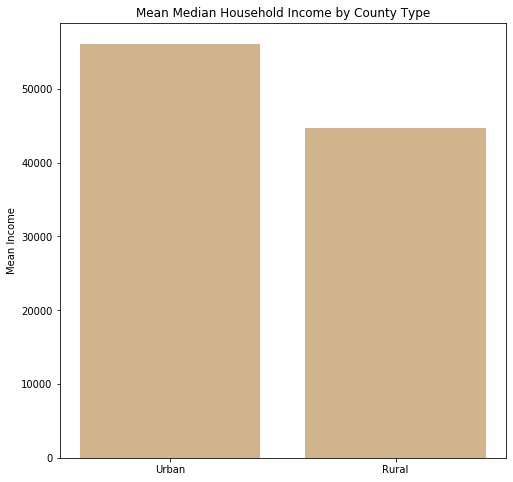

In [237]:
plt.figure(figsize=(8,8))
plt.bar(x, y, color ='tan')
plt.title('Mean Median Household Income by County Type')
plt.ylabel('Mean Income')

plt.show()

### Stat Test 4: Two Means T-Test 
#### Do rural and urban counties have a different rate of uninsured?

In [224]:
import scipy.stats

In [225]:
df_rural = df[df.POPPCT_URBAN <= 75]
df_urban = df[df.POPPCT_URBAN > 75]

In [226]:
len(df_rural)

2091

In [227]:
len(df_urban)

508

In [231]:
rural = df_rural.Median_Household_Income

In [232]:
urban = df_urban.Median_Household_Income

In [233]:
scipy.stats.ttest_ind(rural, urban)

Ttest_indResult(statistic=-19.708604869463954, pvalue=1.0763289819633104e-80)

In [234]:
rural.mean()

44728.4074605452

In [235]:
urban.mean()

56133.580708661415

P-value = 1.07 x 10<sup>-80</sup>, so we can reject the null hypothesis and conclude that there is a significant difference between rural and urban counties and their median household income.